In [5]:
# ___Cell no. 1___

#General libraries
import matplotlib.pyplot as plt
import numpy as np
import glob
# ___Cell no. 2___

#Imports for the Gabor filter
from scipy import ndimage as ndi
from skimage.filters import gabor_kernel
from scipy.stats import kurtosis, skew
# ___Cell no. 3___

#Import for preview of images
from IPython.display import Image, display

In [6]:
# ___Cell no. 4___

#Load zebra images into an array
zebrafolder = './zebra/'
zebra_images = glob.glob('{}*.jpg'.format(zebrafolder))

#Check how many images we have
len(zebra_images)

0

In [7]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import math

def showImagesHorizontally(list_of_files):
    fig = figure(figsize=(20,10))
    number_of_files = len(list_of_files)
    #c=math.ceil((number_of_files)/3)
    for i in range(5):
        a=fig.add_subplot(1,5,i+1)
        image = imread(list_of_files[i])
        imshow(image,cmap='Greys_r')
        axis('off')

IndexError: list index out of range

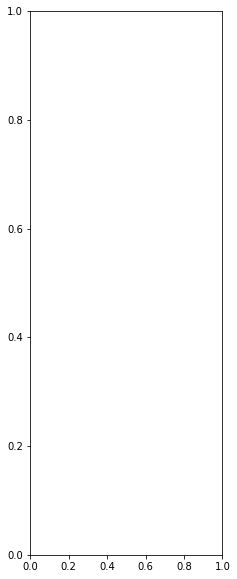

In [8]:
showImagesHorizontally(zebra_images[0:5])

In [ ]:
# ___Cell no. 6___

#Load random images into an array
nozebrafolder = './nozebra/'
nozebra_images = glob.glob('{}*.jpg'.format(nozebrafolder))

#Check how many images we have
len(nozebra_images)

In [ ]:
showImagesHorizontally(nozebra_images[0:5])

Feature extraction 

after looking the featur extraction is the same every where 

In [ ]:
# ___Cell no. 8___

#Function to perform feature extraction using the Gabor filters

def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        #feats[k, 0] = filtered.mean()
        #feats[k, 1] = filtered.var()
        feats[k, 0] = kurtosis(np.reshape(filtered,-1))
        feats[k, 1] = skew(np.reshape(filtered,-1))
    return feats

In [ ]:
# ___Cell no. 9___

#Define the type of Gabor filters we want to use

kernels = []

for sigma in (1,4):
    theta = np.pi/4       #Here theta is set to 45 degrees (pi/4 radians) for all filters
    for frequency in (0.05, 0.25):
        print('theta = {}, sigma = {} frequency = {}'.format(theta, sigma, frequency) )
        kernel = np.real(gabor_kernel(frequency,theta=theta,sigma_x=sigma, sigma_y=sigma))
        kernels.append(kernel)
                         
np.shape(kernels)

In [ ]:
%%time

# ___Cell no. 10___

zebra_feats = np.zeros((len(zebra_images),9)) #Create an array to store our 8 features and the image class
for i, image in enumerate(zebra_images):
    im = plt.imread(image,format='jpeg')
    if len(im.shape) > 2:
        imean = im.mean(axis=2)
    else:
        imean = im
    imfeats = compute_feats(imean,kernels).reshape(-1) #Call the function to perform feature extraction
    zebra_feats[i,:-1] = imfeats 
    zebra_feats[i,-1] = 1        #Class 1 assigned for all zebra images

In [ ]:
%%time

# ___Cell no. 11___

nozebra_feats = np.zeros((len(nozebra_images),9)) #Create an array to store our 8 features and the image class
for i, image in enumerate(nozebra_images):
    im = plt.imread(image,format='jpeg')
    imfeats = compute_feats(im.mean(axis=2),kernels).reshape(-1)
    nozebra_feats[i,:-1] = imfeats 
    nozebra_feats[i,-1] = 0      #Class 0 assigned for all nozebra images

In [ ]:
# ___Cell no. 12___

#combine the datasets
ds = np.concatenate((nozebra_feats,zebra_feats), axis=0)
features = ds[:,:-1]

In [ ]:
# ___Cell no. 13___

from sklearn.preprocessing import MaxAbsScaler
features = MaxAbsScaler().fit_transform(features)

In [ ]:
# ___Cell no. 14___

target = ds[:,-1]

In [ ]:
# ___Cell no. 15___

from sklearn.model_selection import train_test_split

In [ ]:
# ___Cell no. 16___

# Randomly splits the data and respective labels (y values) into a train and test set, the size of the
# test set is specified to be 20%

X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.3,random_state=0)

In [ ]:
# ___Cell no. 17___

#Check the sizes of our training and test sets

print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

In [ ]:
# ___Cell no. 18___

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

In [ ]:
import pandas as pd
# Defining the model
#C = 1.0  # SVM regularization parameter

models = (svm.SVC(kernel='linear'),
            svm.SVC(kernel='sigmoid', gamma=1),
            svm.SVC(kernel='rbf', gamma=1),
            svm.SVC(kernel='poly', degree=1))
a = []
b = []
for clf in models:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_predtrain = clf.predict(X_train)
    a.append(metrics.accuracy_score(y_train , y_predtrain))
    b.append(metrics.accuracy_score(y_test , y_pred))
    
d = {"Model":models,"Test prediction":b, "Train prediction":a}
M = pd.DataFrame(d)
M

using the rbf gives us the higher test and train  accuracy then  we uwe it for the training

In [ ]:
# ___Cell no. 19___

# Create a classifier: a support vector classifier
classifier = svm.SVC(C=1,kernel='rbf',gamma=1)
#fit to the training data
classifier.fit(X_train,y_train)

In [ ]:
# ___Cell no. 20___

# now to Now predict the value of the digit on the test data
y_pred = classifier.predict(X_test)

In [ ]:
# ___Cell no. 21___

print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred))

In [ ]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
km=metrics.confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(km)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('SVM RBF Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test,y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
# ___Cell no. 22___

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, y_pred)))

random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_jobs=4, n_estimators=10, class_weight='balanced')

In [ ]:
clf.fit(X_train,y_train)

In [ ]:
# ___Cell no. 20___

# now to Now predict the value of the digit on the test data
y_pred = clf.predict(X_test)

In [ ]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
km=metrics.confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(km)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('SVM RBF Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test,y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [ ]:
# ___Cell no. 22___

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, y_pred)))

In [ ]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import pickle


DATADIR = r'./downloads/'
CATEGORIES = ['house', 'tree']


for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show() 
        
        break  # we just want one for now so break
    break

In [ ]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in os.listdir(path):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

In [ ]:
print(len(training_data))

In [ ]:
training_data1 = []

def create_training_data1():
#     for category in CATEGORIES:  # do dogs and cats

    path = zebrafolder # create path to dogs and cats
    for zebra in zebrafolder:
        class_num = zebrafolder.index(zebra)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in os.listdir(path):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data1.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data1()

In [ ]:
print(len(training_data1))

In [ ]:
random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])
    

In [ ]:
random.shuffle(training_data1)
for sample in training_data1[:10]:
    print(sample[1])
    

In [ ]:
IMG_SIZE

In [ ]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [ ]:
X = []
y = []

for features,label in training_data1:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [ ]:
pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [ ]:
pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [ ]:
X = X/255

using Deep learning

In [ ]:

# ====================================================================== 
# BUILDING CONVOLUTION NEURAL NETWORK
# ====================================================================== 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time
dense_layers = [0,1,2]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model_cnn = Sequential()

            # Layer1:  Convolution + Max Pooling + Batch Normalization + dropout
            model_cnn.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))
            model_cnn.add(Activation('relu'))
            model_cnn.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
            model_cnn.add(BatchNormalization())
            model_cnn.add(Dropout(0.2))

            # Layer2:  Convolution + Max Pooling + Batch Normalization + dropout
            for l in range(conv_layer-1):
                model_cnn.add(Conv2D(layer_size, (3, 3)))
                model_cnn.add(Activation('relu'))
                model_cnn.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
                model_cnn.add(BatchNormalization())
                model_cnn.add(Dropout(0.2))

        #     # Layer3:  Convolution + Max Pooling + Batch Normalization + dropout
        #     model_cnn.add(Conv2D(256, (3, 3),input_shape = [256,256,3], kernel_regularizer=l2(0.001)))
        #     model_cnn.add(Activation('relu'))
        #     model_cnn.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
        #     model_cnn.add(BatchNormalization())
        #     model_cnn.add(Dropout(0.2))

            # Flatten the output to 1-D
            model_cnn.add(Flatten())
            for _ in range(dense_layer):

                # Layer4: Running a simple NN with 3 layers
                # NN1
                model_cnn.add(Dense(layer_size))
                model_cnn.add(Activation('relu'))
                model_cnn.add(Dropout(0.2))

            # NN2
            model_cnn.add(Dense(1))
            model_cnn.add(Activation('relu'))
            model_cnn.add(Dropout(0.2))

        #     # NN3
        #     model_cnn.add(Dense(units = 128, activation = 'relu' ,kernel_regularizer=l2(0.001)))

        #     model_cnn.add(Dropout(0.2))

            #output
            model_cnn.add(Dense(units = 1, activation = 'sigmoid'))
            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
            # ====================================================================== 
            # COMPILING CONVOLUTION NEURAL NETWORK
            # ====================================================================== 
            from tensorflow.keras.optimizers import Adam
            opt = Adam(lr=0.0005) #Learning rate is half of the default
            model_cnn.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
            model_cnn.summary()

In [ ]:
model_cnn.fit(X,y,epochs=3,batch_size=100,validation_split=0.3,callbacks=[tensorboard])

In [ ]:
model_cnn.save('64x3_CNN2.model')

In [ ]:
import cv2
import tensorflow as tf

CATEGORIES = ['house', 'tree']


def prepare(filepath):
    IMG_SIZEw = 150  # 50 in txt-based
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZEw, IMG_SIZEw))
    return new_array.reshape(-1, IMG_SIZEw, IMG_SIZEw, 1)


model = tf.keras.models.load_model("64x3_CNN2.model")
filename = input('Enter the name of the image: ')
prediction = model.predict([prepare(filename)])
print(prediction)  # will be a list in a list.
print(CATEGORIES[int(prediction[0][0])])

display(Image(filename, height=180, width=180))

In [ ]:
import cv2
import tensorflow as tf

CATEGORIES = ['dog','cat']


def prepare(filepath):
    IMG_SIZEw = 150  # 50 in txt-based
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZEw, IMG_SIZEw))
    return new_array.reshape(-1, IMG_SIZEw, IMG_SIZEw, 1)


model = tf.keras.models.load_model("64x3_CNN1.model")
filename = input('Enter the name of the image: ')
prediction = model.predict([prepare(filename)])
print(prediction)  # will be a list in a list.
print(CATEGORIES[int(prediction[0][0])])

display(Image(filename, height=180, width=180))


In [ ]:
import cv2
import tensorflow as tf

CATEGORIES = ['dog','cat']


def prepare(filepath):
    IMG_SIZEw = 150  # 50 in txt-based
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZEw, IMG_SIZEw))
    return new_array.reshape(-1, IMG_SIZEw, IMG_SIZEw, 1)


model = tf.keras.models.load_model("64x3_CNN.model")
filename = input('Enter the name of the image: ')
prediction = model.predict([prepare(filename)])
print(prediction)  # will be a list in a list.
print(CATEGORIES[int(prediction[0][0])])

display(Image(filename, height=180, width=180))


In [ ]:
import cv2
import tensorflow as tf

CATEGORIES = ['house', 'tree']


def prepare(filepath):
    IMG_SIZEw = 150  # 50 in txt-based
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZEw, IMG_SIZEw))
    return new_array.reshape(-1, IMG_SIZEw, IMG_SIZEw, 1)


model = tf.keras.models.load_model("64x3-CNN.model")
filename = input('Enter the name of the image: ')
prediction = model.predict([prepare(filename)])
print(prediction)  # will be a list in a list.
print(CATEGORIES[int(prediction[0][0])])

display(Image(filename, height=180, width=180))